# Clarity

Super resolution on faces

## Introduction
This notebook is an attempt to follow the notorious paper [Image Super-Resolution Using Deep Convolutional Networks](https://arxiv.org/abs/1501.00092) to achieve super resolution on human faces.


## Idea

Using a CNN trained with downscaled images to improve the quality of images in low resolution. Using a set of images 256x256 and the same set resized to 64x64 a model can be trained to restore common traits on human faces, thus making it possible to restore other photos which are not available in high resolution

## Model

### Input Layer:
The model takes a low-resolution image as input, typically a face image with reduced resolution.

### Convolutional Layers:
SRCNN consists of three convolutional layers. These layers are responsible for learning hierarchical features from the low-resolution input.

### Non-linear Activation:
ReLU (Rectified Linear Unit) activation function is applied after each convolutional layer. ReLU introduces non-linearity to the model and helps in learning complex patterns.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SRCNN(nn.Module):
    def __init__(self, lr=1e-6, out_1 = 128, out_2 = 64, kernel_size = 9, kernel_size2 = 5):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, out_1, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(out_1, out_2, kernel_size=kernel_size2, padding=kernel_size2//2)
        self.conv3 = nn.Conv2d(out_2, 3, kernel_size=kernel_size2, padding=kernel_size2//2)

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.losses = []
        self.psnr = []

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        return x

    def fit(self, x, y):
        self.optimizer.zero_grad()
        output = self(x)
        loss = self.loss_fn(y, output)
        loss.backward()
        loss.item()
        self.losses.append(loss.item())
        #self.psnr.append(10 * torch.log10(1 / loss))
        self.optimizer.step()

    def predict(self, x):
        return self.forward(x)
    

    def save(self, set_size, epoch):
        torch.save(self.state_dict(), f"models/{set_size}-{epoch}.pth")

    def load(self, path):
        self.load_state_dict(torch.load(path))


s_from = 256
s_to = 64 

## Image feed
Each image starts with size 1024x1024. Such high format is for an initial stage very inefficient as it occupies a lot of memory. To make the learning phase as much as possible, all pictures in formats 256x256 and 64x64 are loaded in (G)Ram for fast access. On my local setup with an Nvidia GeForce 2060S 8 Gb of Gram were more than sufficient to host 1000 images

In [2]:

from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os

def to_tensor(image):
    tensor = transforms.ToTensor()(image).to(device)
    return tensor

class CustomDataset(Dataset):
    def __init__(self):
        self.images_src = os.listdir("images/1024")
        self.limit = len(self.images_src) 
        self.xs = []
        self.ys = []
        for idx in tqdm(range(len(self.images_src)), desc="Resizing and potentially loading into GRAM"):
            y = Image.open("images/1024/{}".format(self.images_src[idx])).resize((s_from, s_from), Image.BICUBIC)
            x = y.resize((s_to, s_to), Image.BICUBIC).resize((s_from, s_from), Image.BICUBIC)
            self.xs.append(to_tensor(x))
            self.ys.append(to_tensor(y))


    def __len__(self):
        return min( len(self.images_src), self.limit)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

# free gpu
torch.cuda.empty_cache()
dataset = CustomDataset()
batch_size = 50

Resizing and potentially loading into GRAM: 100%|██████████| 1000/1000 [00:48<00:00, 20.47it/s]


## Variations

Since the paper is not incentred on faces, the hyperparameters of the model have to be validated, so many variations were tested, and so (almost) every combination of:
- first layer 64, 128, 256 neurons
- second layer 64, 128, 256 neurons
- first layer 9, 5, 3 kernel size
- second and third layer 9, 5, 3 kernel size


Some variations were left out since an incredible high latencies were registered. The first layer consisting of 256 neurons prooved to be extremely inefficient with sizes over 64 on the second layer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset.limit = 50
batch_size = 5
epochs = 200 
padding = 20
dataloader = DataLoader(dataset, batch_size=batch_size)
stats = []
for out_1 in [64, 128, 256]:
    for out_2 in [64, 128, 256]:
        if out_1 != out_2:
            for kernel_size in [9, 5, 3]:
                for kernel_size2 in [9, 5, 3]:
                    if out_1 == 256 and out_2 != 64:
                        # other cases taking too long
                        continue
                    model = SRCNN(out_1=out_1, out_2=out_2, kernel_size=kernel_size, kernel_size2=kernel_size2).to(device)
                    torch.cuda.empty_cache()

                    for epoch in tqdm(range(epochs)):
                        for x, y in dataloader:
                            model.fit(x, y)
                    
                    losses = np.array(model.losses)
                    losses = losses.reshape(-1, dataset.__len__() // batch_size)
                    losses = np.mean(losses, axis=1)

                    stats.append([out_1, out_2, kernel_size, kernel_size2, losses[-1]])
                    print(f"Loss for out_1={out_1}, out_2={out_2}, kernel_size={kernel_size}, kernel_size2={kernel_size2}: {losses[-1]}")

df = pd.DataFrame(stats, columns=['run', 'seconds', 'loss', 'out_1', 'out_2', 'kernel_1', 'kernel_2'])
csv_file = 'output.csv'
df.to_csv(csv_file, index=False)

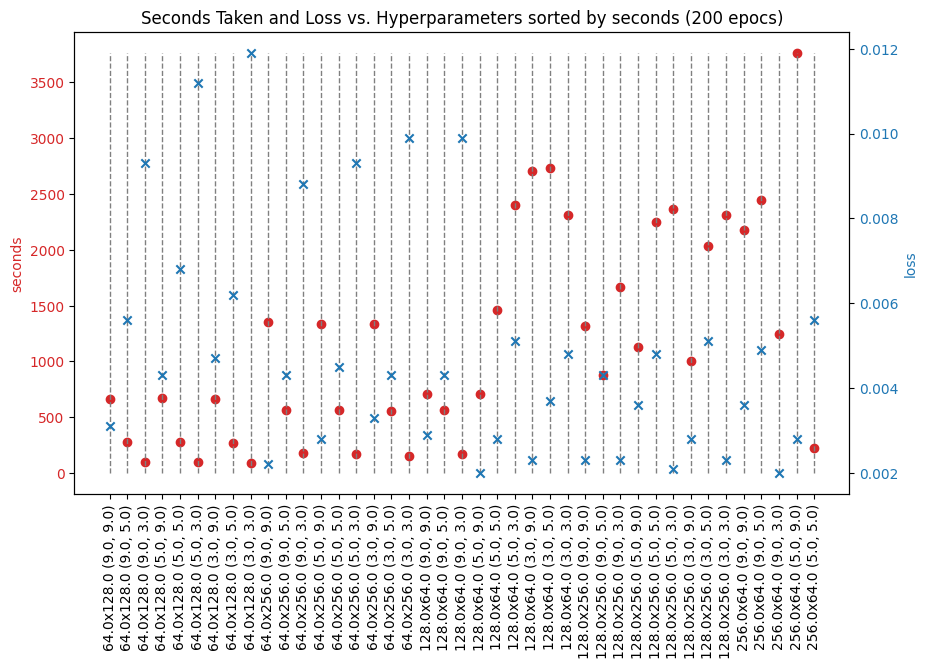

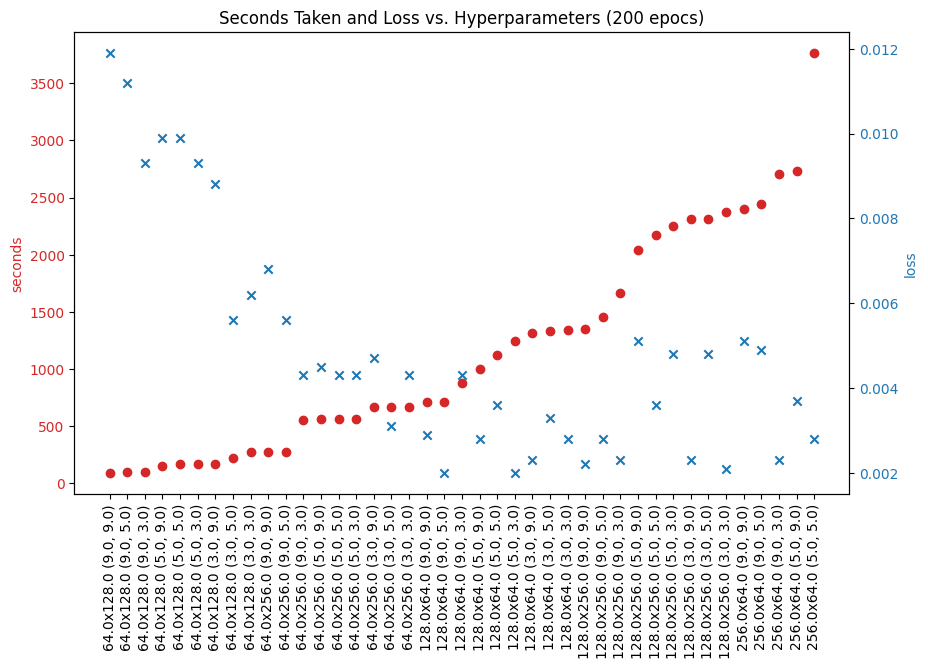

In [61]:
import pandas as pd

df = pd.read_csv("params.csv")

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_ylabel('seconds', color='tab:red')
ax1.scatter(df['run'], df['seconds'], color='tab:red', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('loss', color='tab:blue')
ax2.scatter(df['run'], df['loss'], color='tab:blue', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:blue')

for i, row in df.iterrows():
    ax1.plot([row['run'], row['run']], [0, df['seconds'].max()], color='gray', linestyle='--', linewidth=1)

labels = []
for i, row in df.iterrows():
    label = f"{row['out_1']}x{row['out_2']} ({row['kernel_1']}, {row['kernel_2']})"
    labels.append(label)
ax1.set_xticks(df['run'])
ax1.set_xticklabels(labels, rotation=90, ha='center')

plt.title('Seconds Taken and Loss vs. Hyperparameters sorted by seconds (200 epocs)')
plt.show()


df = df.sort_values(by='seconds')
df['time_rank'] = range(1, len(df) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_ylabel('seconds', color='tab:red')
ax1.scatter(df['time_rank'], df['seconds'], color='tab:red', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('loss', color='tab:blue')
ax2.scatter(df['time_rank'], df['loss'], color='tab:blue', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:blue')

labels = []
for i, row in df.iterrows():
    label = f"{row['out_1']}x{row['out_2']} ({row['kernel_1']}, {row['kernel_2']})"
    labels.append(label)
ax1.set_xticks(df['run'])
ax1.set_xticklabels(labels, rotation=90, ha='center')

plt.title('Seconds Taken and Loss vs. Hyperparameters (200 epocs)')
plt.show()


# Best Hyperparameters

One of the parameters cited by the paper (128, 64) with kernels of (9, 5) seems to be the most efficent model given one of the smalles losses in a pretty low time of about 10-15 minutes with 200 epocs. 

So, let's train this model!

## Do more images help the process?

The paper states to have trained their model with 91 images once and with 395,909 images a second time. They state to see a similar trend just slightly increasing, so here follows a check, trying to see what the difference is between 50, 100, 500 and 1000 images to train the model. Important to notice on the chart, is that the amount of work done is the same for all cases, which means for smaller sets to train over and over again on more epochs on the same set.

What the paper states is also true for this test. The trend stays very similar, as it seems to be very slightly better on bigger data sets

Training 50 images over 200 epochs...


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 100%|██████████| 200/200 [03:46<00:00,  1.13s/it]


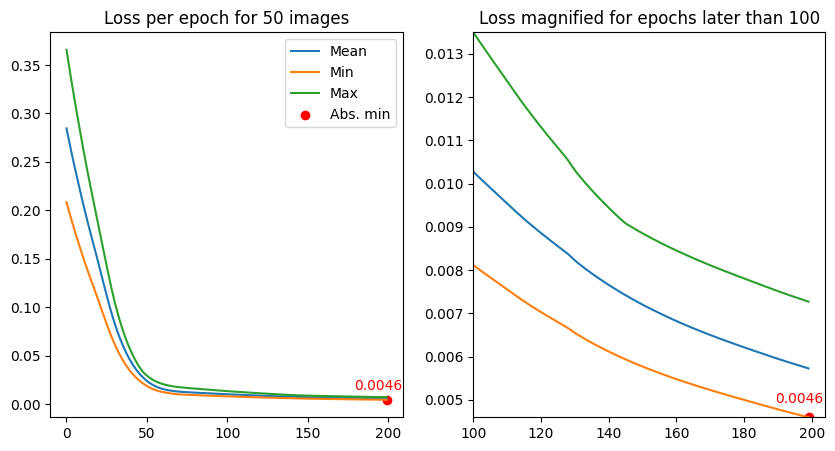

Training 100 images over 100 epochs...


Epoch: 100%|██████████| 100/100 [03:46<00:00,  2.26s/it]


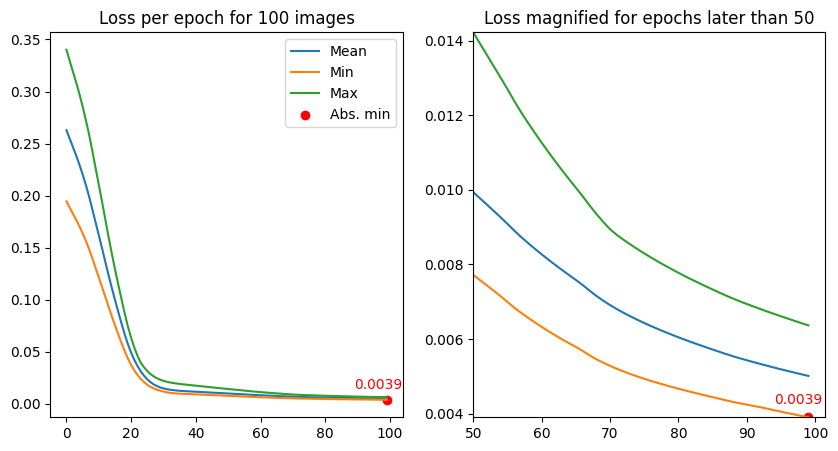

Training 500 images over 20 epochs...


Epoch: 100%|██████████| 20/20 [03:45<00:00, 11.29s/it]


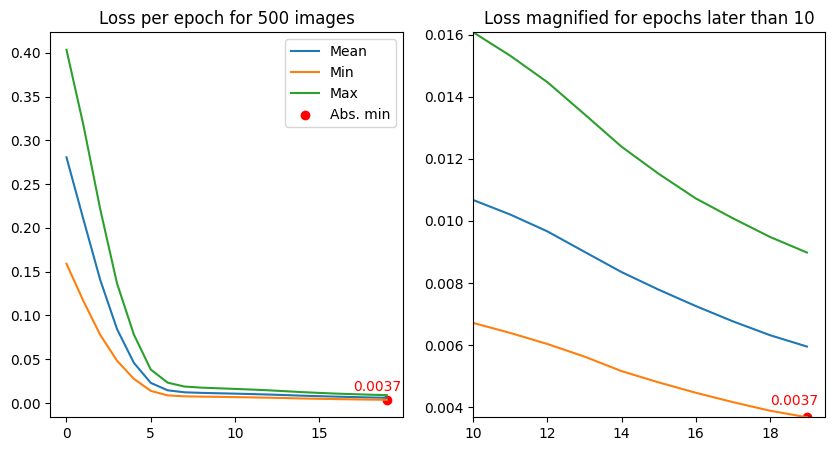

Training 1000 images over 10 epochs...


Epoch: 100%|██████████| 10/10 [03:45<00:00, 22.53s/it]


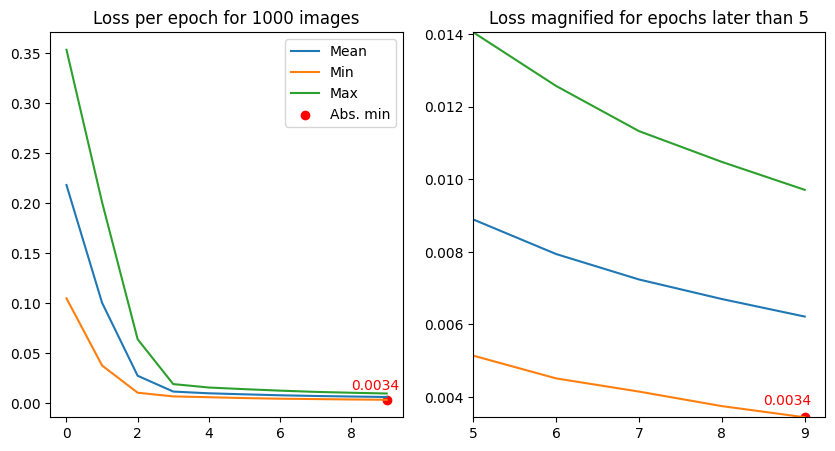

In [4]:
import matplotlib.pyplot as plt
import numpy as np
iterations = 10000 

for limit in [50, 100, 500, 1000]:
    epochs = iterations // limit
    torch.cuda.empty_cache()
    model = SRCNN()
    model.to(device)
    dataset.limit = limit
    batch_size = 5
    dataloader = DataLoader(dataset, batch_size=batch_size)
    print(f"Training {dataset.__len__()} images over {epochs} epochs...")
    for epoch in tqdm(range(epochs), position=0, leave=True, desc="Epoch"):
        for X_batch, Y_batch in dataloader:
            model.fit(X_batch, Y_batch)
    losses = np.array(model.losses)
    losses = losses.reshape(-1, dataset.__len__() // batch_size)
    losses_mean = np.mean(losses, axis=1)
    losses_min = np.min(losses, axis=1)
    losses_max = np.max(losses, axis=1)
    padding = epochs * 0.1
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Loss per epoch for {dataset.__len__()} images")
    plt.plot(losses_mean, label="Mean")
    plt.plot(losses_min, label="Min")
    plt.plot(losses_max, label="Max")
    plt.scatter(np.argmin(losses_min), np.min(losses_min), label="Abs. min", color="red")
    plt.text(np.argmin(losses_min) - padding, np.min(losses_min) + 0.01, "%.4f"%np.min(losses_min), color="red")
    plt.legend()
    plt.subplot(1, 2, 2)
    padding = epochs // 2 * 0.1
    padding_y = np.max(losses_max[epochs//2:]) * 0.025
    plt.title(f"Loss magnified for epochs later than {epochs//2}")
    plt.plot(losses_mean, label="Mean")
    plt.plot(losses_min, label="Min")
    plt.plot(losses_max, label="Max")
    plt.xlim(epochs//2, epochs-1 + padding /2)
    plt.ylim(np.min(losses_min[epochs//2:]), np.max(losses_max[epochs//2:]))
    plt.scatter(np.argmin(losses_min), np.min(losses_min), label="Abs. min", color="red")
    plt.text(np.argmin(losses_min) - padding, np.min(losses_min) + padding_y, "%.4f"%np.min(losses_min), color="red")
    plt.show()

# Best model

So the only thing left to do now is to train the model for quite a bit and see the results with the hyperparameter chosed before and 1000 images.

For instance, inside the repository, there are 2 results of the trained sets: 1 after 25 epochs and 1 after 1800 (which took 6 hours locally).
The following code can be use to train the model and optionally continue from a pre-trained set

In [19]:

model = SRCNN()
model.to(device)
epochs = 1
last_epoch = 1800
if last_epoch != 0:
    print(f"Continuing from epoch {last_epoch}")
    model.load(f"models/{dataset.__len__()}-{last_epoch}.pth")

dataset.limit = 1000
print(f"Training {dataset.__len__()} images over {epochs} epochs...")
for epoch in tqdm(range(last_epoch, epochs + last_epoch), position=0, leave=True, desc="Epoch"):
    for X_batch, Y_batch in dataloader:
        model.fit(X_batch, Y_batch)
    print(f"Loss: {model.losses[-1]}")
    model.save(dataset.__len__(), epoch)

Continuing from epoch 1800
Training 1000 images over 1 epochs...


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 100%|██████████| 1/1 [00:21<00:00, 21.52s/it]

Loss: 0.0007446030504070222


# Results

The results are not even close to the papers ones since the model was trained for too short, but in general a couple of things can be observed:
- Images go up in quality
    - Pixels inside the picture are not as noticeable as the downscaled version
    - Common face properties are restored pretty decently
- There are a lot of artifacts
    - Generally seem to disapper with training (most visible in images 5, 6 and 7)
- Lost details cannot be recovered
    - Some details get lost when lowering the resolution. Those details cannot be recovered and are lost for good.
    - One good example is the light reflection in the eyes on image 3: the white cannot really be recovered


## So why is it not even near to the paper?


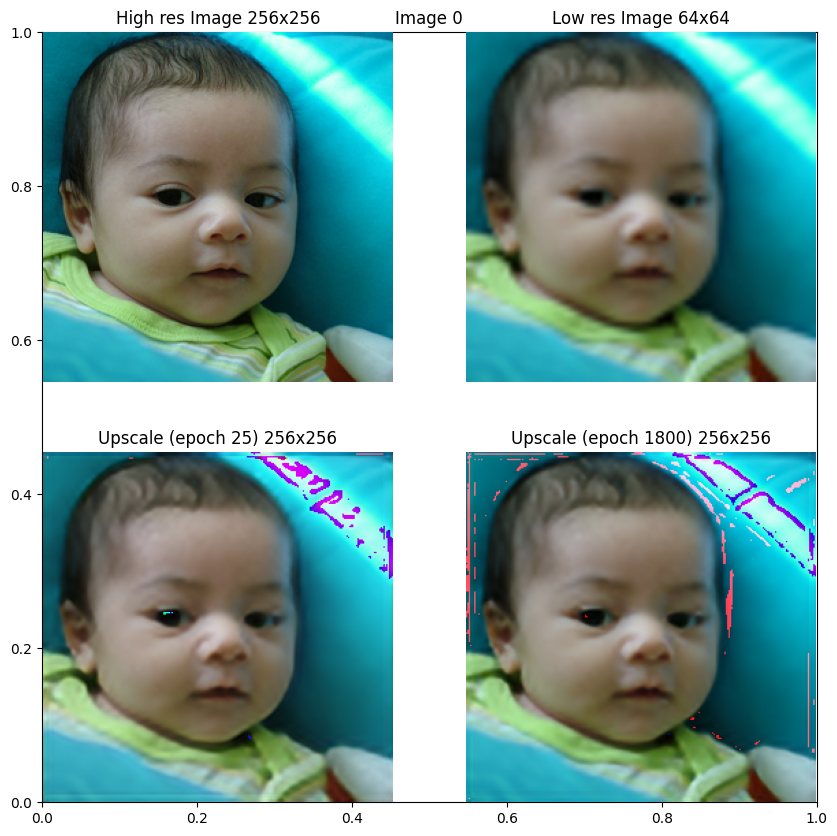

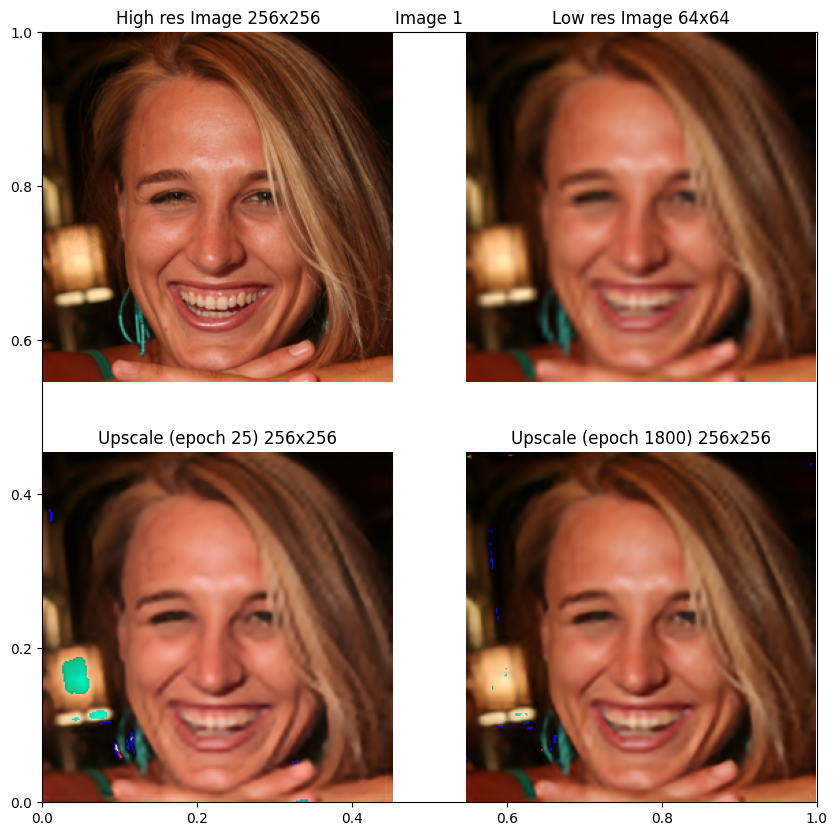

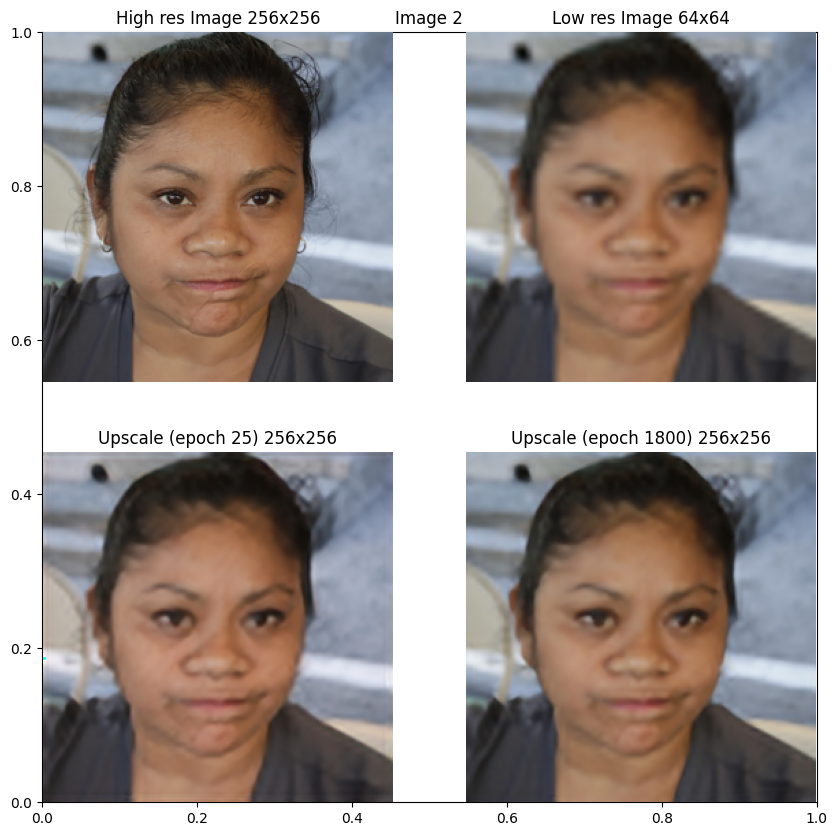

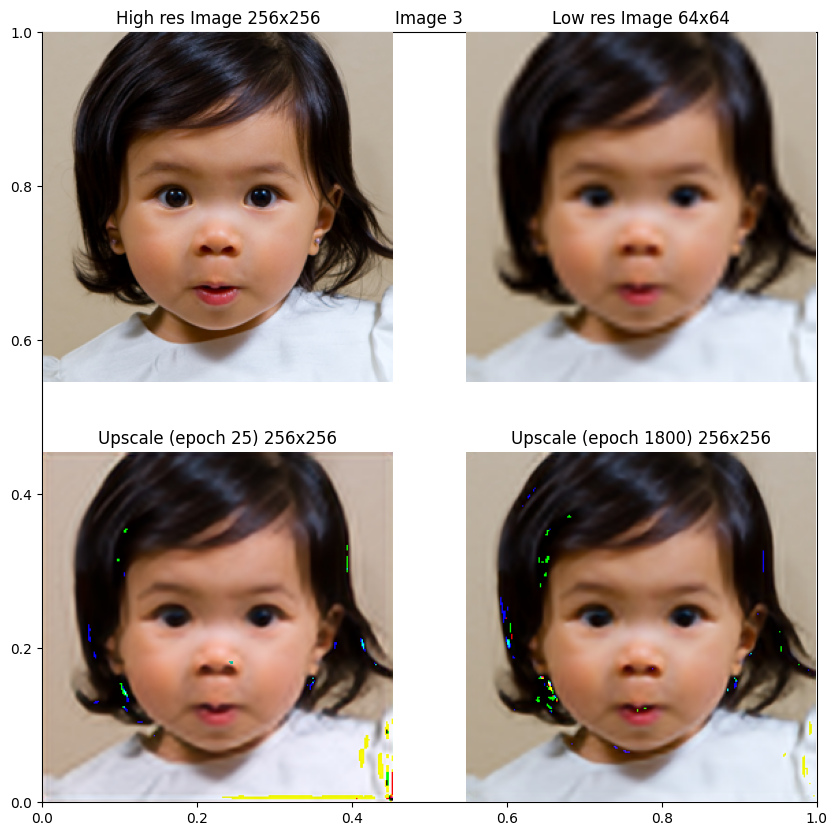

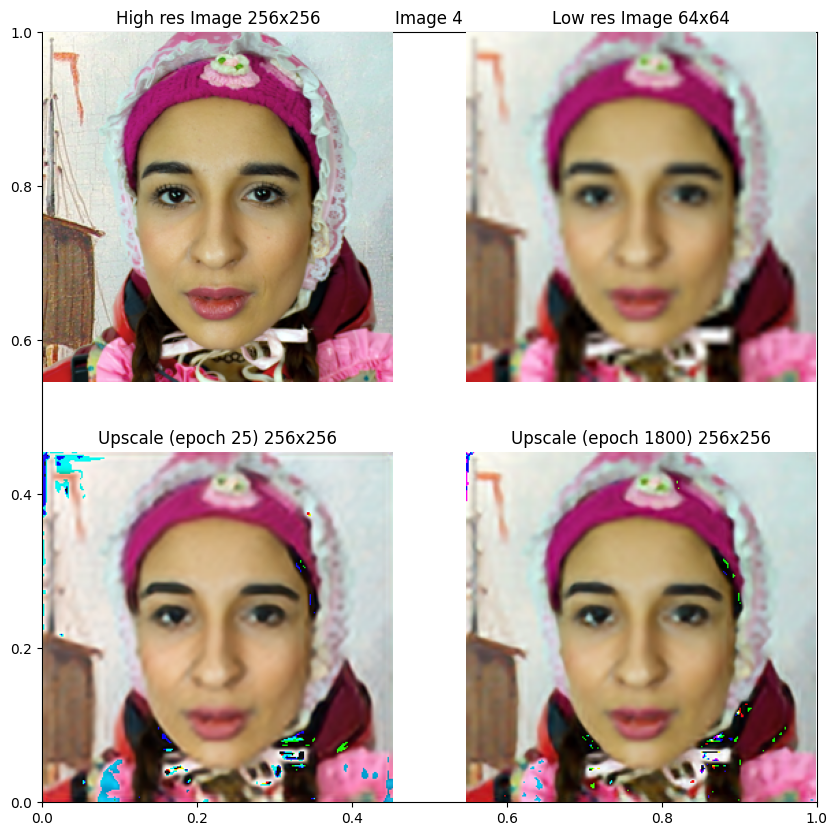

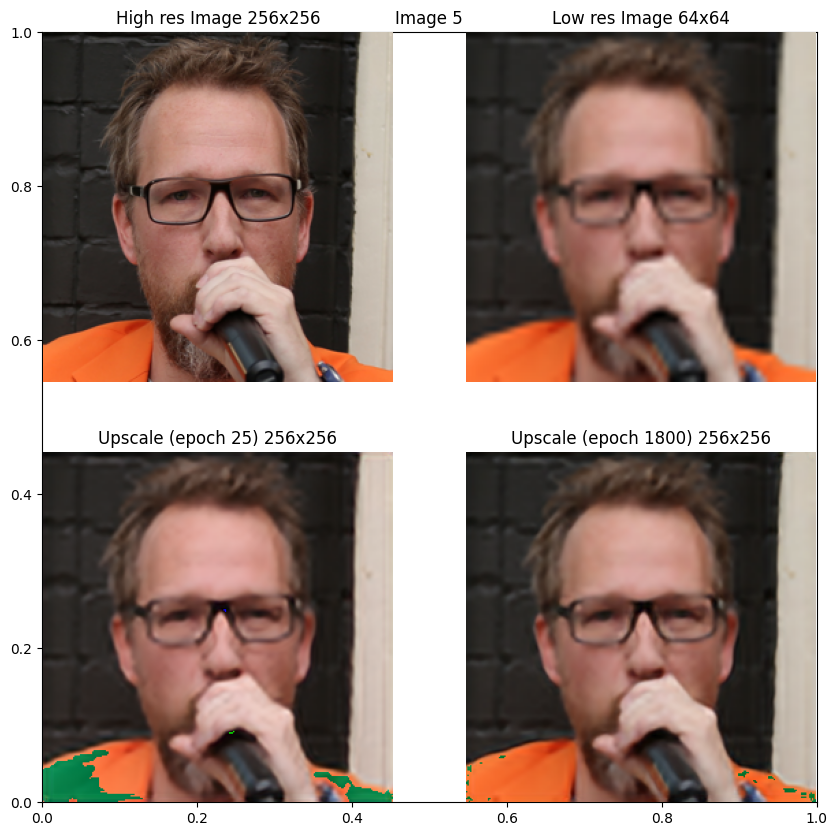

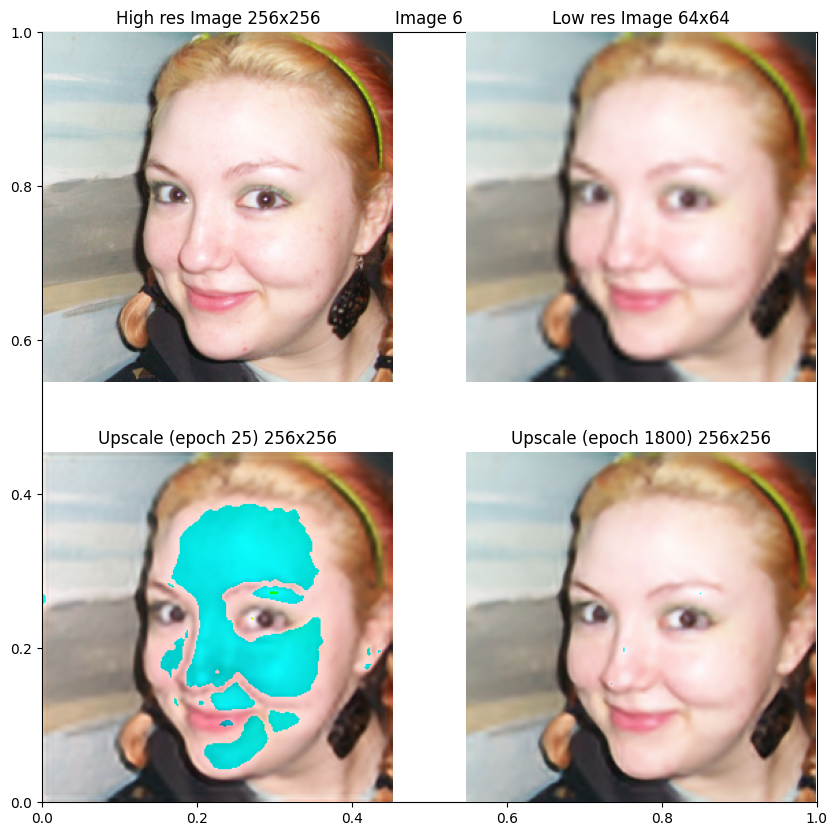

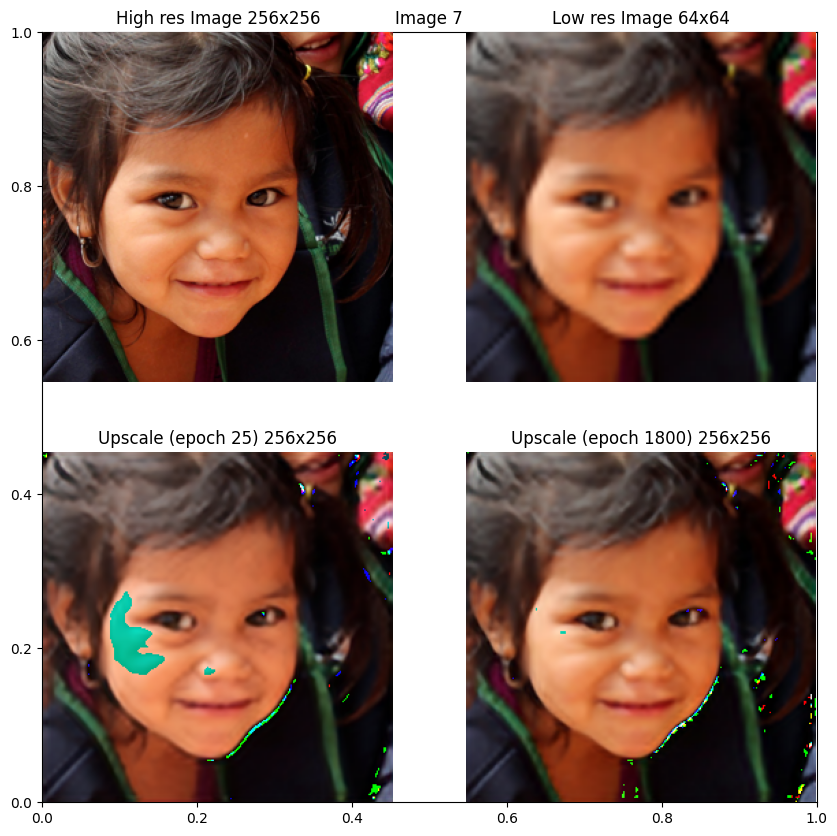

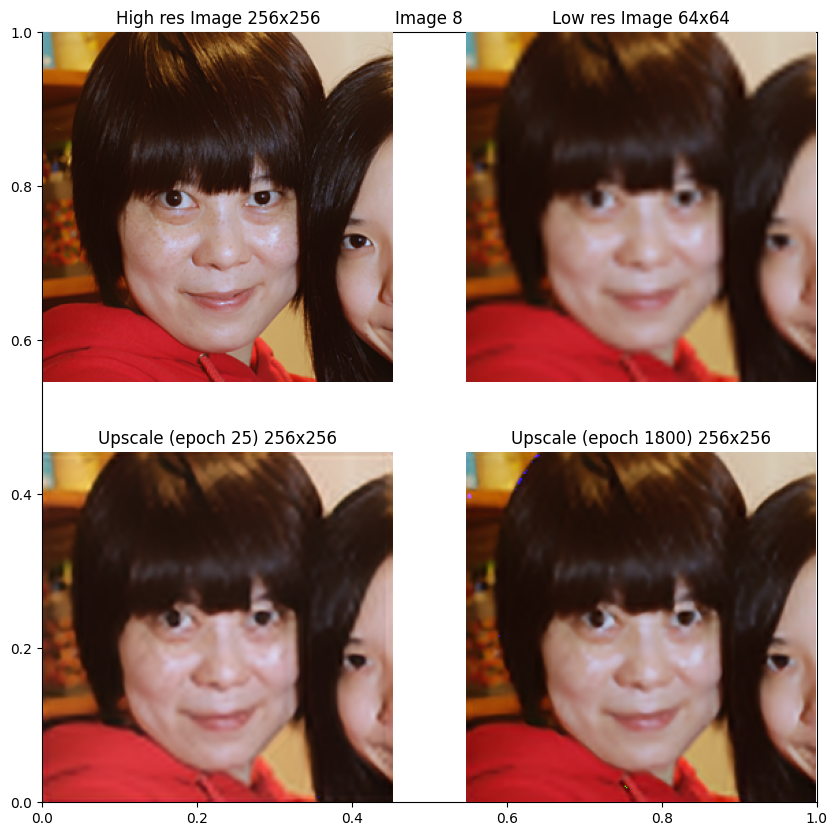

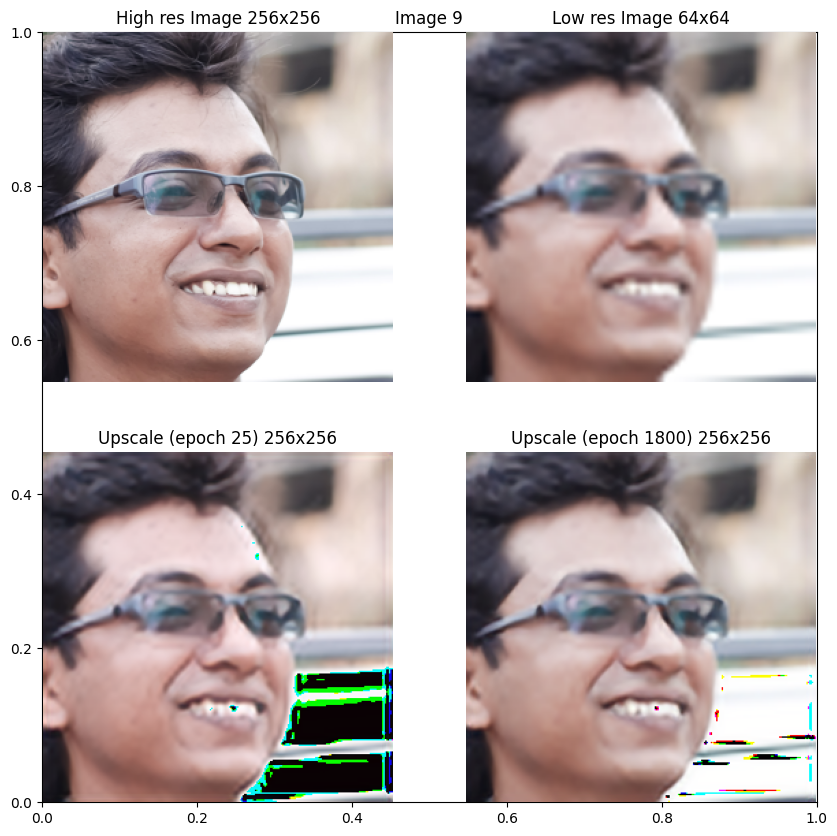

In [63]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

def to_tensor(image):
    return transforms.ToTensor()(image).to(device)

def to_image(tensor):
    return transforms.ToPILImage()(tensor)

def test_image(model, index, epoch_a, epoch_b):
    image_path = f"images/1024/0000{index}.png"

    input_image = Image.open(image_path).resize((s_from, s_from), Image.BICUBIC)
    input_image_resized = input_image.resize((s_to, s_to), Image.BICUBIC).resize((s_from, s_from), Image.BICUBIC)


    input_tensor = to_tensor(input_image_resized)
    model.load(f"models/1000-{epoch_a}.pth")
    model.eval()
    with torch.no_grad():
        output_tensor = model.predict(input_tensor)
    output_image_a =to_image(output_tensor.cpu())

    model.load(f"models/1000-{epoch_b}.pth")
    model.eval()
    with torch.no_grad():
        output_tensor = model.predict(input_tensor)
    output_image_b =to_image(output_tensor.cpu())

    input_image = to_image(to_tensor(np.array(input_image)))
    input_image_resized = np.array(input_image_resized)

    plt.figure(figsize=(10, 10))
    plt.title(f"Image {index}")
    plt.subplot(2, 2, 1)
    plt.title(f'High res Image {s_from}x{s_from}')
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title(f'Low res Image {s_to}x{s_to}')
    plt.imshow(input_image_resized)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title(f'Upscale (epoch {epoch_a}) {s_from}x{s_from}')
    plt.imshow(output_image_a)
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title(f'Upscale (epoch {epoch_b}) {s_from}x{s_from}')
    plt.imshow(output_image_b)
    plt.axis('off')
    plt.show()


model = SRCNN()
model.to(device)


for i in range(0, 10):
    test_image(model, i, 25, 1800)



## How does it perform on images not in the set?

The results are even more impressive on one of my pictures as a kid (20 years old photo). Important to notice here is that the quality loss is not the same. On this test picture, the quality is not linear, some traits are more out of focus than others due to camera quality, aging and scanning.


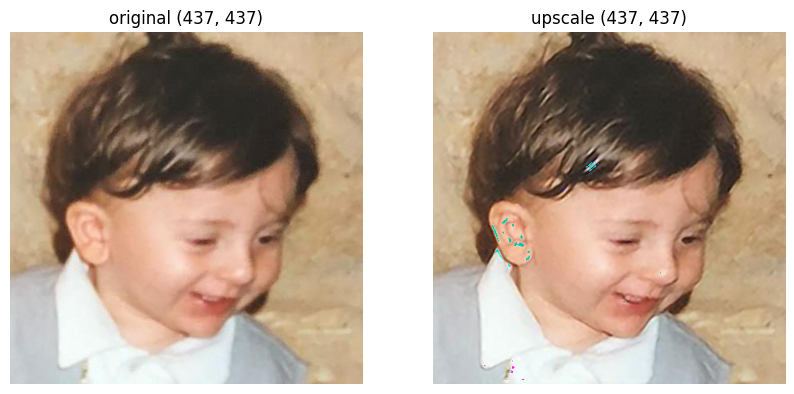

In [35]:

import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

def to_tensor(image):
    return transforms.ToTensor()(image).to(device)

def to_image(tensor):
    return transforms.ToPILImage()(tensor)

def test_real(model, image_path):
    model.eval()

    input_image = Image.open(image_path)
    input_tensor = to_tensor(input_image)


    with torch.no_grad():
        output_tensor = model.predict(input_tensor)

    output_tensor = output_tensor.cpu()

    output_image = to_image(output_tensor)
    input_image = to_image(to_tensor(np.array(input_image)))

    output_image.save(f"images/out_{image_path.split('/')[-1]}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'original {input_image.size}')
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'upscale {output_image.size}')
    plt.imshow(output_image)
    plt.axis('off')

    plt.show()

model = SRCNN()
model.to(device)

model.load(f"models/1000-1800.pth")
test_real(model, "images/im_old.jpeg")
# test_real(model, "images/uncle.jpg")
# test_real(model, "images/aunt.jpg")
# test_real(model, "images/brother.jpg")

## License disclaimer
As a training dataset the following set was used https://github.com/NVlabs/ffhq-dataset which is under https://creativecommons.org/licenses/by-nc-sa/4.0/ usage as this repository
